# Problem Statement: Finding which factors determine the popularity of tweets

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv_file_path = '/content/drive/MyDrive/ukraine.csv'
data = pd.read_csv(csv_file_path)
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1.498450e+18,Rob Smith 🇨🇦 🇺🇦,"Ontario, Canada","Proud Canadian 🇨🇦, ❤️ baseball ⚾️, ❤️ history,...",18/2/2013 18:05,395,1898,4137,False,28/2/2022 23:55,@kiraincongress Photos of rally in support of ...,NaN,Twitter for iPhone,0,0,False
1,1.498450e+18,Frags,Chicago,ay yo video games\nMarried To My Best Friend @...,18/5/2013 16:53,10523,269,3051,False,28/2/2022 23:55,#Russia propaganda on #Twitter attempting to d...,"['Russia', 'Twitter', 'Ukraine']",Twitter for iPhone,0,1,False
2,1.498450e+18,Mark Malahosky 🇺🇦,"Webster, NY",Pharmacist practicing at a Federally Qualified...,14/7/2015 12:38,184,164,38434,False,28/2/2022 23:55,@1Arnold_Friend @MaryEmBern @13WHAM Putin lack...,['SlavaUkraini'],Twitter for iPhone,0,1,False
3,1.498450e+18,oz,"Hlavní město Praha, Česká repu",foodandfilms,21/7/2013 11:38,17,93,7907,False,28/2/2022 23:54,"@profgalloway Dear prof, I have been following...",NaN,Twitter for Android,0,1,False
4,1.498450e+18,Sydfish 🇺🇦🇺🇦🇺🇦🇺🇦,"California, USA",Soccer mom with a punk rock heart!!!!🛑NO LISTS...,20/12/2008 22:41,9136,8070,167748,False,28/2/2022 23:54,I’ve done more than 100 in St. Petersburg. \n\...,NaN,Twitter for iPhone,0,0,False


In [ ]:
data.shape

(30468, 16)

### **DATA PRE-PROCESSING**

Cleaning text by removing stopwords, changing to lowercase, removing punctuation etc.

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Define a function for cleaning of textual data
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http?://\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Join the tokens back into a single string
    clean_text = ' '.join(tokens)
    return clean_text

# Apply the cleaning function to the 'text' column
data['clean_text'] = data['text'].apply(clean_text)

# Display the cleaned text
print(data['clean_text'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0        photos rally support ukraine toronto canada su...
1        propaganda attempting diminish everything figh...
2                                            putin lackeys
3        dear prof following podcasts time thought sort...
4        ive done st petersburg dm would like blurb rus...
                               ...                        
30463    still one moving videos seen war air raid sire...
30464    im war brings much death said amp since invade...
30465    small town ukraine saw russian army bbc news h...
30466    right rest world quaking boots wrong putin mus...
30467    good morning kyiv still ukrainian httpstcojarr...
Name: clean_text, Length: 30468, dtype: object


80% of rows contain favorites & retweets = NULL which skews the results of EDA and ML and is not relevant to predicting popularity of tweet. Will remove.

In [ ]:
total_rows =  data.shape[0]

# Drop rows with '0' as values in 'retweets' and 'favorites' columns
data = data[(data['retweets'] != 0) & (data['favorites'] != 0)]

remaining_rows = data.shape[0]
removed_rows = total_rows - remaining_rows
print("No. of rows removed :", removed_rows)
print("No. of rows remaining :", remaining_rows)
print()

data.describe()

No. of rows removed : 24243
No. of rows remaining : 6225



,id,user_followers,user_friends,user_favourites,retweets,favorites
count,6.225000e+03,6.225000e+03,6225.000000,6.225000e+03,6225.000000,6225.000000
mean,1.501236e+18,1.637826e+04,3864.596145,5.606661e+04,8.269398,34.767068
std,2.807968e+15,2.069220e+05,11010.058436,1.017485e+05,56.628555,260.329088
min,1.498440e+18,0.000000e+00,0.000000,0.000000e+00,1.000000,1.000000
25%,1.498980e+18,2.420000e+02,285.000000,2.085000e+03,1.000000,2.000000
50%,1.500040e+18,1.198000e+03,1178.000000,1.363700e+04,2.000000,4.000000
75%,1.503070e+18,4.891000e+03,3691.000000,6.143400e+04,3.000000,12.000000
max,1.506940e+18,5.639953e+06,177291.000000,1.036956e+06,1922.000000,9451.000000


In [ ]:
# Convert no. of retweets and no. of favorites into categorical variables

# Define the bin edges
retweet_bins = [1, 2, 3, float('inf')]  # 25% percentile (Q1): 1 and 75% percentile (Q3): 3
favorite_bins = [float('-inf'), 4, 12, float('inf')] # 25% percentile (Q1): 1 and 75% percentile (Q3): 12

# Define the bin labels: 75% percentile (Q3) and above is 'high', 25% percentile (Q1) and below is 'low'
retweet_labels = ['low', 'medium', 'high']
favorite_labels = ['low', 'medium', 'high']

# Apply binning to create categorical variables
data['retweets_likelihood'] = pd.cut(data['retweets'], bins=retweet_bins, labels=retweet_labels, right=False)
data['favorites_likelihood'] = pd.cut(data['favorites'], bins=favorite_bins, labels=favorite_labels, right=False)

# Display the DataFrame with the new categorical columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6225 entries, 10 to 30467
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    6225 non-null   float64 
 1   user_name             6225 non-null   object  
 2   user_location         4674 non-null   object  
 3   user_description      5880 non-null   object  
 4   user_created          6225 non-null   object  
 5   user_followers        6225 non-null   int64   
 6   user_friends          6225 non-null   int64   
 7   user_favourites       6225 non-null   int64   
 8   user_verified         6225 non-null   bool    
 9   date                  6225 non-null   object  
 10  text                  6225 non-null   object  
 11  hashtags              3895 non-null   object  
 12  source                6225 non-null   object  
 13  retweets              6225 non-null   int64   
 14  favorites             6225 non-null   int64   
 15  is_retw

Old definition of popularity : by quartile
* 1st quartile: low retweet likelhood
* 2nd quartile: medium
* 3rd quartile: high

In [ ]:
# Count the number of tweets in each category
retweet_counts = data['retweets_likelihood'].value_counts()
favorite_counts = data['favorites_likelihood'].value_counts()

# Print the thresholds and counts
print("Range for 'Low' Retweets Likelihood: (<=1 retweet)")
print("Range for 'Medium' Retweets Likelihood: (2-3 retweets)")
print("Range for 'High' Retweets Likelihood: (>3 retweets)")

print(f"\nNumber of Tweets in 'Low' Retweets Likelihood: {retweet_counts['low']}")
print(f"Number of Tweets in 'Medium' Retweets Likelihood: {retweet_counts['medium']}")
print(f"Number of Tweets in 'High' Retweets Likelihood: {retweet_counts['high']}")


Range for 'Low' Retweets Likelihood: (<=1 retweet)
Range for 'Medium' Retweets Likelihood: (2-3 retweets)
Range for 'High' Retweets Likelihood: (>3 retweets)

Number of Tweets in 'Low' Retweets Likelihood: 3026
Number of Tweets in 'Medium' Retweets Likelihood: 1101
Number of Tweets in 'High' Retweets Likelihood: 2098


retweets_likelihood
low       3026
high      2098
medium    1101
Name: count, dtype: int64


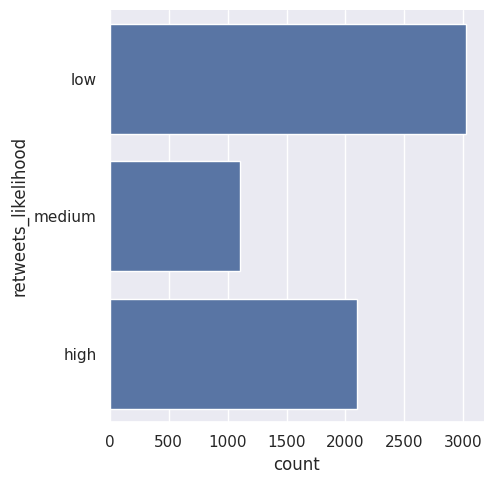

In [ ]:
print(data["retweets_likelihood"].value_counts())
sb.catplot(y = "retweets_likelihood", data = data, kind = "count")

New definition (which we use for EDA and ML): by IQR
* not pop: < Q3 + 1.5 IQR
* pop: Q3 + 1.5 IQR < pop < Q3 + 1.5 IQR (regular outlier)
* very pop: > Q3 + 1.5 IQR + 3 IQR (extreme outlier)

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(data['retweets'], 25)
Q3 = np.percentile(data['retweets'], 75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the threshold for identifying outliers based on IQR
outlier_threshold = 1.5 * IQR

# Define the threshold for identifying extreme outliers within outliers
extreme_outlier_threshold = 3 * IQR

# Categorize tweets based on their popularity levels
for index, row in data.iterrows():
    if Q3 + outlier_threshold <= row['retweets'] < Q3 + outlier_threshold + extreme_outlier_threshold:
        data.at[index, 'popularity'] = 'very pop'
    elif row['retweets'] >= Q3 + outlier_threshold:
        data.at[index, 'popularity'] = 'pop'
    else:
        data.at[index, 'popularity'] = 'not pop'

# Print the ranges for each category
print("Range for 'not pop': (0, {:.2f})".format(Q3 + outlier_threshold))
print("Range for 'pop': ({:.2f}, {:.2f})".format(Q3 + outlier_threshold, Q3 + outlier_threshold + extreme_outlier_threshold))
print("Range for 'very pop': ({:.2f}, infinity)".format(Q3 + outlier_threshold + extreme_outlier_threshold))
print()

# Count the number of tweets in each category
popularity_counts = data['popularity'].value_counts()

print("Number of Tweets in Each Category:")
print(popularity_counts)


Range for 'not pop': (0, 6.00)
Range for 'pop': (6.00, 12.00)
Range for 'very pop': (12.00, infinity)

Number of Tweets in Each Category:
popularity
not pop     5206
pop          514
very pop     505
Name: count, dtype: int64


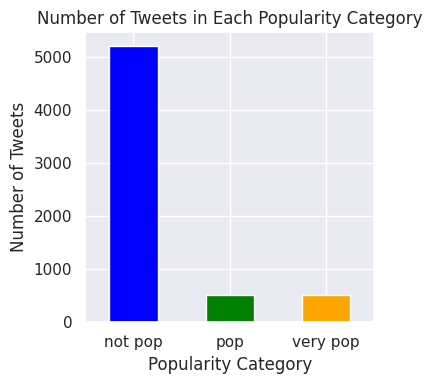

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' contains the categorized tweets as per the code snippet provided

# Count the number of tweets in each category
popularity_counts = data['popularity'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(4, 4))
popularity_counts.plot(kind='bar', color=['blue', 'green', 'orange'])
plt.title('Number of Tweets in Each Popularity Category')
plt.xlabel('Popularity Category')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


comment: having less pop and very pop of only 500 each compared to 5k+ non-pop tweets may make machine learning model less accurate

In [ ]:
#adding text length to dataframe
data['text_length'] = data['text'].apply(len)

# Display the DataFrame with the added 'text_length' column
print(data[['text', 'text_length']])

                                                    text  text_length
10     Starlink arrived pretty quickly in #Ukraine \n...          101
13     Swearing is an art form in Ukraine. #SlavaUkra...           81
14     @strategywoman Much love from Southern Highlan...          114
19     @Ukraine I knew almost nothing of Ukrainian pe...          137
24     Show your support for the Ukrainian people, #S...          137
...                                                  ...          ...
30455  And now for a beautiful site in Ukraine, the T...          140
30456  Let's help heroes now,\nwe must do more to Ukr...          134
30460  Ukraine: The small town which managed to block...          135
30461  👇Please read\n#DefeatPutin \n#StandWithUkraine...          132
30467  Good morning Kyiv. You are still Ukrainian!  #...           91

[6225 rows x 2 columns]


In [ ]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
id,0
user_name,0
user_location,1551
user_description,345
user_created,0
user_followers,0
user_friends,0
user_favourites,0
user_verified,0
date,0


## EXPLORATORY DATA ANALYSIS

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data[['user_verified', 'retweets']].corr()

# Extract the correlation coefficient between 'user_verified' and 'retweets'
correlation = correlation_matrix.loc['user_verified', 'retweets']

print("Correlation between user_verified and retweets:", correlation)


Correlation between user_verified and retweets: 0.16496708853757838


In [ ]:
# Calculate the correlation matrix
correlation_matrix = data[['user_favourites', 'retweets']].corr()

# Extract the correlation coefficient between 'user_favourites' and 'retweets'
correlation = correlation_matrix.loc['user_favourites', 'retweets']

print("Correlation between user_favourites and retweets:", correlation)


Correlation between user_favourites and retweets: 0.0027776675346140307


In [ ]:
# Calculate the correlation matrix
correlation_matrix = data[['user_friends', 'retweets']].corr()

# Extract the correlation coefficient between 'user_friends' and 'retweets'
correlation = correlation_matrix.loc['user_friends', 'retweets']

print("Correlation between user_friends and retweets:", correlation)


Correlation between user_friends and retweets: 0.05026139496280648


# Favorites and popularity

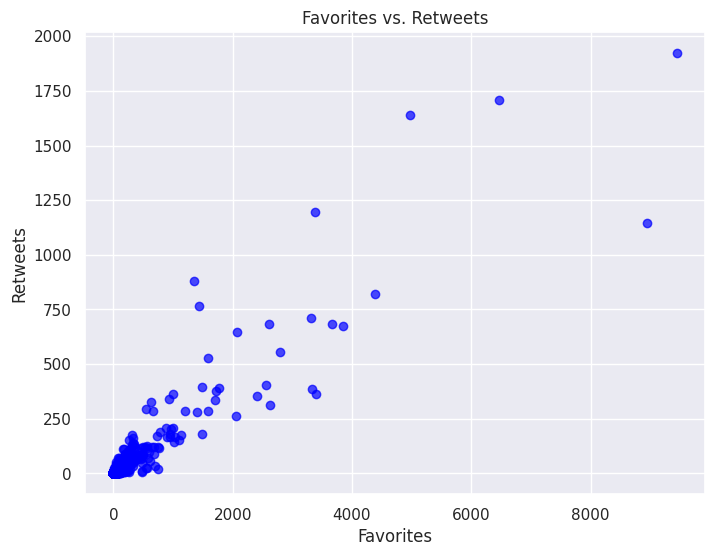

Correlation coefficient: 0.9287517474046315


In [ ]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data['favorites'], data['retweets'], color='blue', alpha=0.7)
plt.title('Favorites vs. Retweets')
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.grid(True)
plt.show()

# Calculate correlation coefficient
correlation = data['favorites'].corr(data['retweets'])
print("Correlation coefficient:", correlation)

Sentiment Analysis: analyzing a tweet's polarity and subjectivity

In [ ]:
from typing_extensions import dataclass_transform
from textblob import TextBlob

# Assuming your cleaned text is stored in a variable named 'clean_text'
clean_text = data['clean_text']  # Assuming 'df' is your DataFrame containing the cleaned text column

# Perform sentiment analysis on each cleaned text
sentiments = clean_text.apply(lambda text: TextBlob(text).sentiment)

# Extract polarity and subjectivity scores
polarity_scores = sentiments.apply(lambda sentiment: sentiment.polarity)
subjectivity_scores = sentiments.apply(lambda sentiment: sentiment.subjectivity)

# Add polarity and subjectivity scores to the DataFrame
data['polarity'] = polarity_scores
data['subjectivity'] = subjectivity_scores

# Display the DataFrame with polarity and subjectivity scores
data[['clean_text', 'polarity', 'subjectivity']].head()

,clean_text,polarity,subjectivity
10,starlink arrived pretty quickly httpstcodbgztafkp,0.291667,0.75
13,swearing art form ukraine httpstcoradnnep,0.000000,0.00
14,much love southern highlands nsw australia htt...,0.250000,0.30
19,knew almost nothing ukrainian people past week...,-0.250000,0.25
24,show support ukrainian people tomorrow quad pm...,0.000000,0.00


**polarity**: This column contains the polarity scores assigned to each cleaned text. Polarity is a measure of how positive, negative, or neutral a piece of text is. Polarity scores range from -1 to 1, where negative values indicate negative sentiment, positive values indicate positive sentiment, and 0 indicates neutral sentiment.

**subjectivity**: This column contains the subjectivity scores assigned to each cleaned text. Subjectivity is a measure of how opinionated or subjective a piece of text is. Subjectivity scores range from 0 to 1, where 0 indicates very objective (factual) text and 1 indicates very subjective (opinionated) text.

In [ ]:
# Filter positive polarity
positive_df = data[data['polarity'] > 0]

# Filter negative polarity
negative_df = data[data['polarity'] < 0]

# Filter neutral tweets
neutral_df = data[data['polarity'] ==0]

# Add columns for positive and negative polarity to the main DataFrame
data['positive_polarity'] = positive_df['polarity']
data['negative_polarity'] = negative_df['polarity']
data['neutral_polarity'] = neutral_df['polarity']
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6225 entries, 10 to 30467
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    6225 non-null   float64 
 1   user_name             6225 non-null   object  
 2   user_location         4674 non-null   object  
 3   user_description      5880 non-null   object  
 4   user_created          6225 non-null   object  
 5   user_followers        6225 non-null   int64   
 6   user_friends          6225 non-null   int64   
 7   user_favourites       6225 non-null   int64   
 8   user_verified         6225 non-null   bool    
 9   date                  6225 non-null   object  
 10  text                  6225 non-null   object  
 11  hashtags              3895 non-null   object  
 12  source                6225 non-null   object  
 13  retweets              6225 non-null   int64   
 14  favorites             6225 non-null   int64   
 15  is_retw

# Text length and popularity

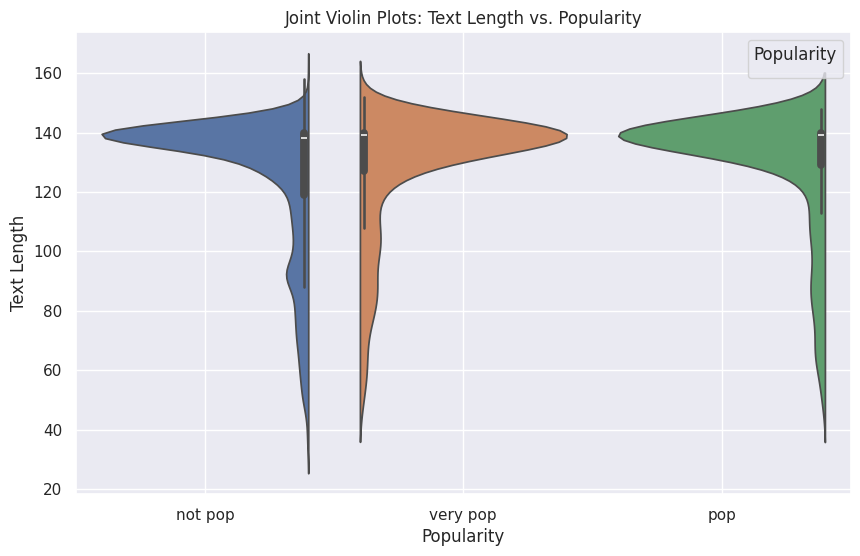

In [ ]:
# Categorize retweet counts into 'popularity' categories
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Creating joint violin plots using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x='popularity', y='text_length', data=data, hue='popularity', split=True)
plt.title('Joint Violin Plots: Text Length vs. Popularity')
plt.xlabel('Popularity')
plt.ylabel('Text Length')
plt.grid(True)
plt.legend(title='Popularity')
plt.show()


comment: the more popular a tweet, the longer the tweet length. Although differences are small.

**Finding relationship between sentiments and popularity**





Time series of number of positive and negative tweets against time (15 days total)
* note that accuracy of time series may be low as pattern only shows sentiments
across one month with missing days in between.

<ipython-input-21-650ed33b04a1>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data['date'])


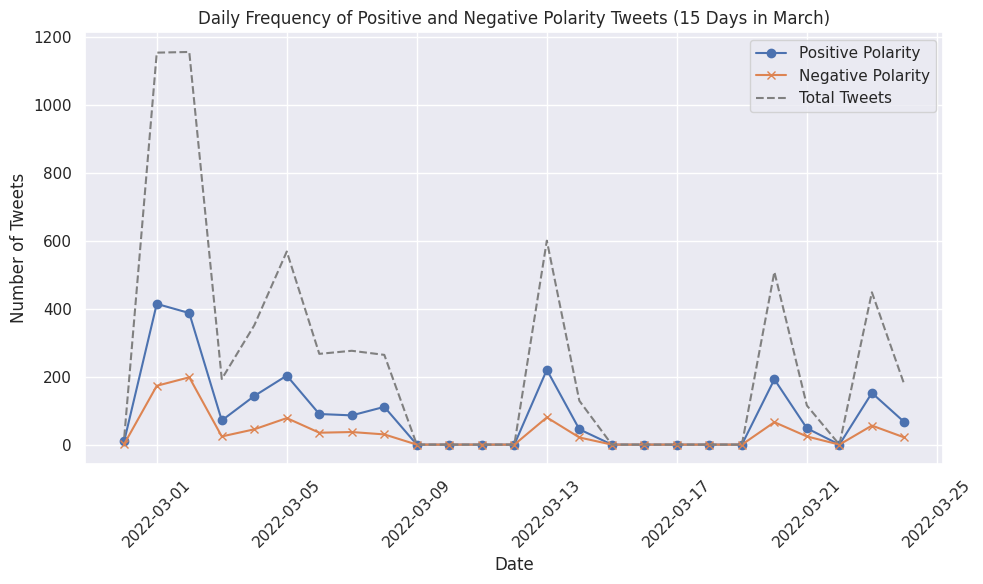

In [ ]:
# Convert 'date' column to datetime if it's not already in datetime format
data['date'] = pd.to_datetime(data['date'])

# Count total tweets per day
total_tweets_per_day = data.groupby(pd.Grouper(key='date', freq='D')).size()

# Filter tweets with positive polarity and count per day
positive_tweets_per_day = data[data['positive_polarity'].notna()].groupby(pd.Grouper(key='date', freq='D')).size()

# Filter tweets with negative polarity and count per day
negative_tweets_per_day = data[data['negative_polarity'].notna()].groupby(pd.Grouper(key='date', freq='D')).size()

# Remove days where either positive or negative tweets are zero
nonzero_positive_tweets = positive_tweets_per_day
nonzero_negative_tweets = negative_tweets_per_day

# Plot the time series for non-zero days
plt.figure(figsize=(10, 6))
plt.plot(positive_tweets_per_day.index, nonzero_positive_tweets.values, label='Positive Polarity', marker='o')
plt.plot(negative_tweets_per_day.index, nonzero_negative_tweets.values, label='Negative Polarity', marker='x')
plt.plot(total_tweets_per_day.index, total_tweets_per_day.values, label='Total Tweets', linestyle='--', color='grey')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Daily Frequency of Positive and Negative Polarity Tweets (15 Days in March)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-22-3ef9e6f97689>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='popularity', y='positive_polarity', data=data, palette='Set2')
<ipython-input-22-3ef9e6f97689>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='popularity', y='absolute_negative_polarity', data=data, palette='Set2')


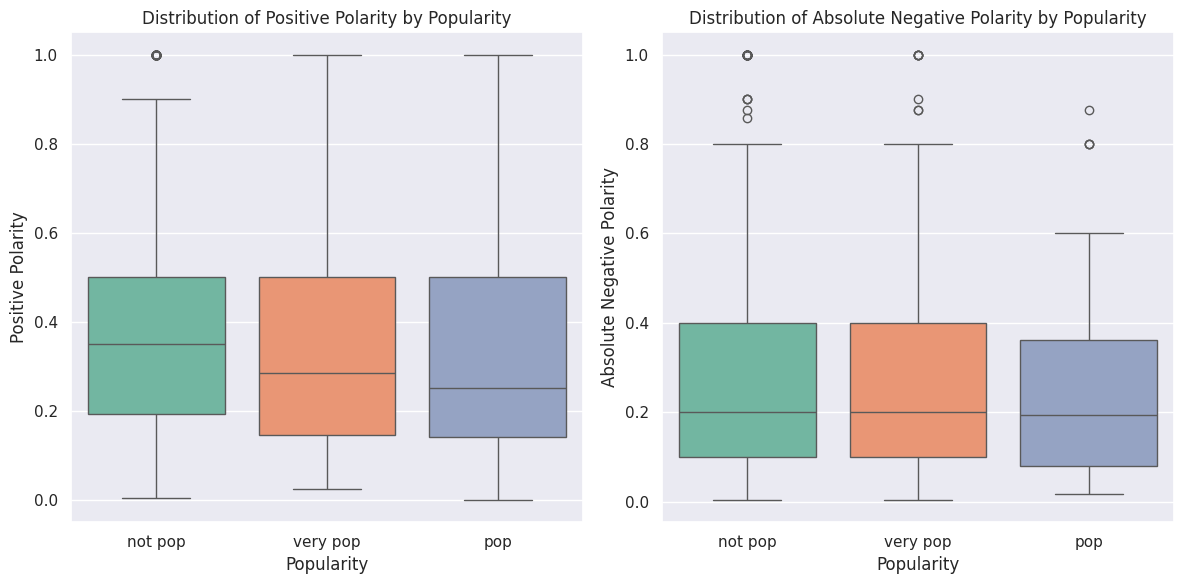

In [ ]:
# Take absolute values of negative polarity
data['absolute_negative_polarity'] = data['negative_polarity'].abs()

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Plot Positive Polarity by Popularity (subplot 1)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sb.boxplot(x='popularity', y='positive_polarity', data=data, palette='Set2')
plt.title('Distribution of Positive Polarity by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Positive Polarity')

# Plot Absolute Negative Polarity by Popularity (subplot 2)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sb.boxplot(x='popularity', y='absolute_negative_polarity', data=data, palette='Set2')
plt.title('Distribution of Absolute Negative Polarity by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Absolute Negative Polarity')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


Comment: tweets that are very popular are slightly lower in positiveness than the rest which are not so popular. They score slightly higher for negativity, although difference not significant.

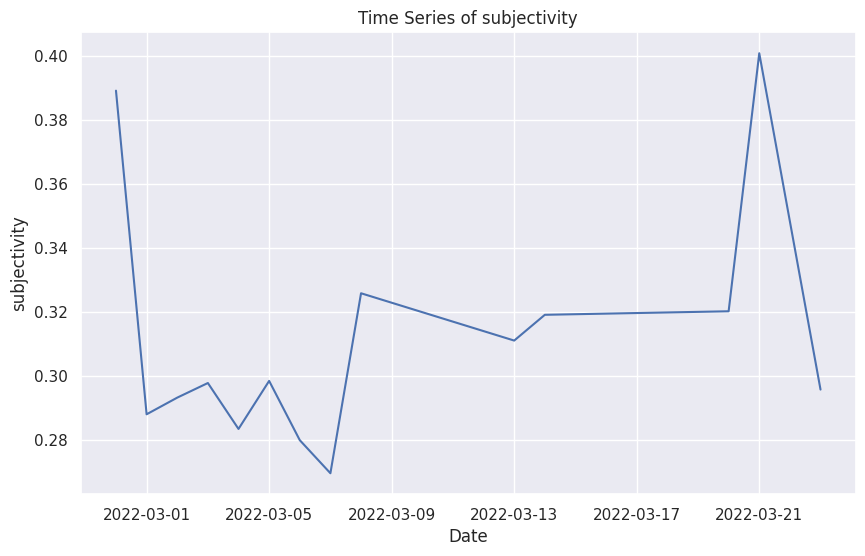

In [ ]:
data['date'] = pd.to_datetime(data['date'])
filtered_data = data[(data['date'] >= '2022-02-28') & (data['date'] <= '2022-03-24')]

grouped_data = filtered_data.groupby(filtered_data['date'].dt.date)['subjectivity'].mean()

plt.figure(figsize=(10,6))
plt.plot(grouped_data.index, grouped_data)
plt.xlabel('Date')
plt.ylabel('subjectivity')
plt.title('Time Series of subjectivity')
plt.show()

comment: no clear trend

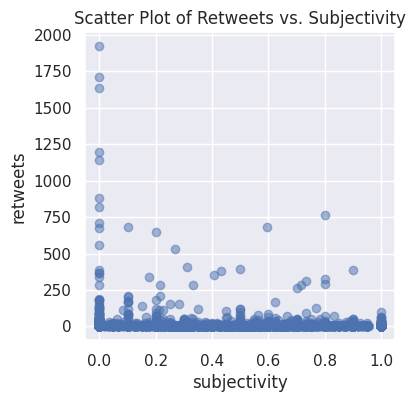

Correlation coefficient: -0.025485878145381474


In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(data['subjectivity'], data['retweets'], alpha=0.5)
plt.title('Scatter Plot of Retweets vs. Subjectivity')
plt.xlabel('subjectivity')
plt.ylabel('retweets')
plt.grid(True)
plt.show()

# Calculate correlation coefficient
correlation = data['subjectivity'].corr(data['retweets'])
print("Correlation coefficient:", correlation)

# Common words founds in popular tweets

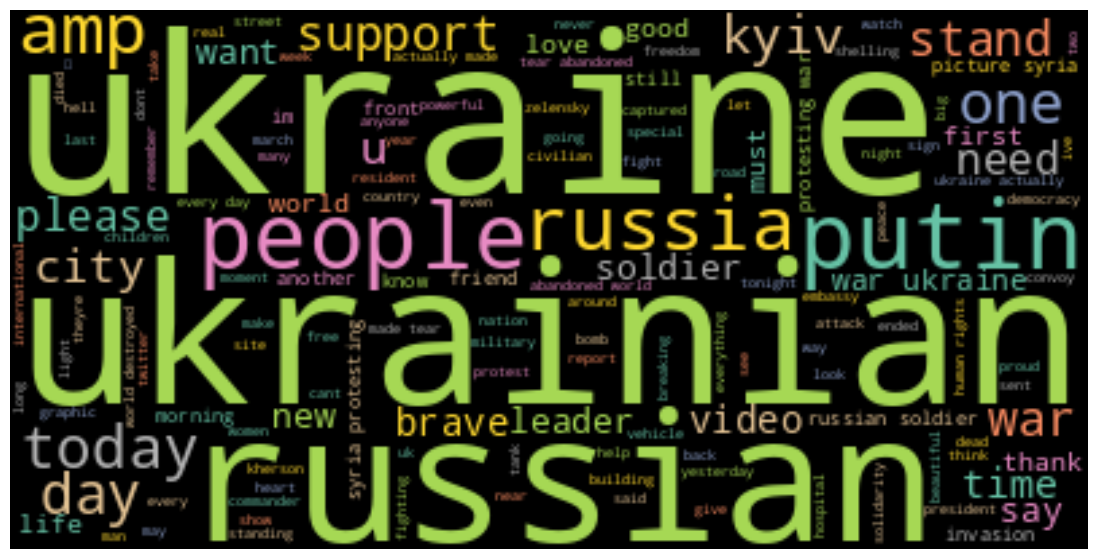

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def generate_wcloud(text, colormap='plasma'):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="Black",colormap='Set2')
    wordcloud.generate(text)

    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

# Word Cloud for common words in popular tweets
pos = data.loc[data.popularity=="pop"].clean_text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

- finding most popular tweets using outliers, which is same definition as 'pop' tweets


object


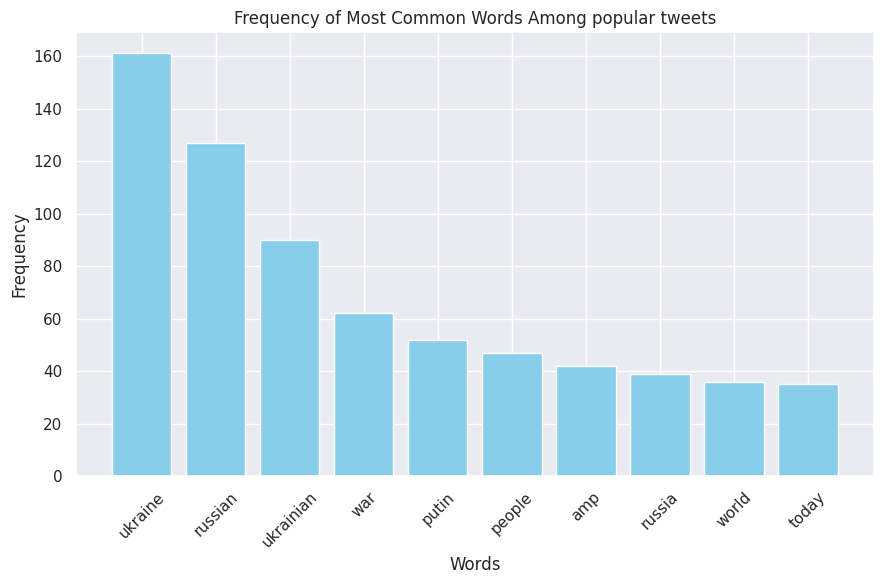

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import Counter

# Assuming 'data' is your DataFrame containing 'clean_text' and 'retweets' columns

# Check data type of 'clean_text' column
print(data['clean_text'].dtype)

# Handle missing values in 'clean_text' column
data = data.dropna(subset=['clean_text'])

# Check NLTK installation and import
# Make sure NLTK is installed using 'pip install nltk'

# Calculate the Interquartile Range (IQR) for 'retweets'
Q1 = data['retweets'].quantile(0.25)
Q3 = data['retweets'].quantile(0.75)
IQR = Q3 - Q1

# Define the threshold for identifying outliers based on IQR
outlier_threshold = 1.5 * IQR

# Filter the DataFrame to include only outliers based on IQR
outliers = data[data['retweets'] > (Q3 + outlier_threshold)]

# Tokenize the text associated with outliers and flatten the list of tokens
outlier_tokens = [word_tokenize(str(text)) for text in outliers['clean_text']]
outlier_tokens_flat = [token for sublist in outlier_tokens for token in sublist]

# Count the occurrences of each word in the outlier tokens
word_counts = Counter(outlier_tokens_flat)

# Get the top 10 most common words among outliers
top_words = word_counts.most_common(10)

# Extract top words and their frequencies for plotting
words, frequencies = zip(*top_words)

# Plot histogram of the frequency of most common words
plt.figure(figsize=(9, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of Most Common Words Among popular tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Add a column indicating how many 'top words appearing in popular tweets' appear in each tweet (below)

In [ ]:
from collections import Counter

# Define common words
common_words = ['ukraine', 'ukrainian', 'russian', 'war', 'putin', 'people', 'amp', 'russia', 'world', 'today']

# Create a function to count common words in each row of text
def count_common_words(text):
    word_counts = Counter(word_tokenize(text))
    common_words_count = sum(word_counts[word] for word in common_words)
    return common_words_count if common_words_count > 0 else 0

# Apply the function to each row of text in the DataFrame
data['common_words_count'] = data['clean_text'].apply(count_common_words)

data[['clean_text', 'common_words_count']].head()

,clean_text,common_words_count
10,starlink arrived pretty quickly httpstcodbgztafkp,0
13,swearing art form ukraine httpstcoradnnep,1
14,much love southern highlands nsw australia htt...,0
19,knew almost nothing ukrainian people past week...,3
24,show support ukrainian people tomorrow quad pm...,2


In [ ]:
data['common_words_count'].describe()

count    6225.000000
mean        0.662008
std         0.877898
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: common_words_count, dtype: float64

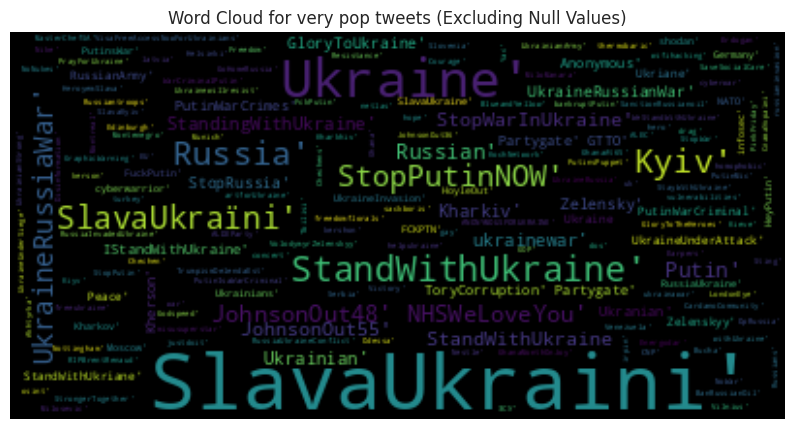

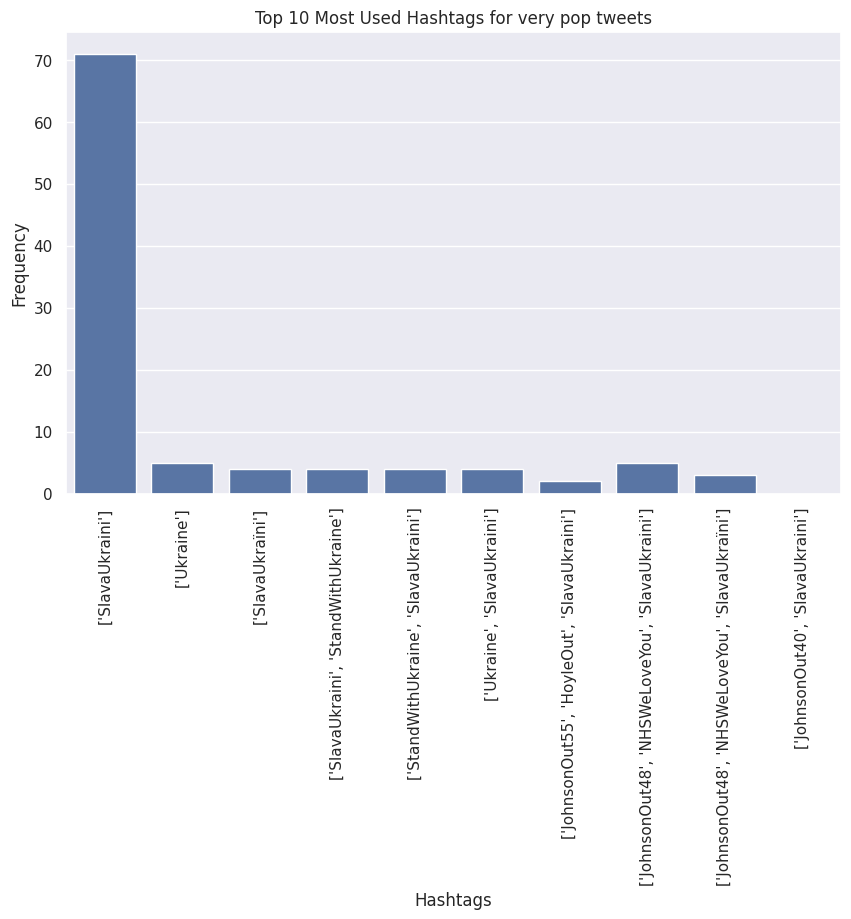

In [ ]:
# Remove rows with null values in 'hashtags' column
data_copy1 = data.copy()
data_copy1.dropna(subset=['hashtags'], inplace=True)


# Word cloud for tweets with high retweets (excluding null values)
pos = data_copy1.loc[(data_copy1.popularity == "very pop") & (data_copy1.hashtags.notnull()), 'hashtags']
text = " ".join(review for review in pos.astype(str))

wordcloud = WordCloud(background_color='black').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for very pop tweets (Excluding Null Values)')
plt.show()

# Count plot for most used hashtags for tweets with high retweets
plt.figure(figsize=(10, 6))
sb.countplot(data=data_copy1[data_copy1['popularity'] == "very pop"], x='hashtags', order=data_copy1['hashtags'].value_counts().index[:10])
plt.title('Top 10 Most Used Hashtags for very pop tweets')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


Comment: no other frequently used hashtag other than SlavaUkraini. hashtag feature not useful

Clustering tweets by topic (total of 5 dominant topics)

Topic 0: 0.028*"russian" + 0.021*"not" + 0.019*"#slavaukraini" + 0.015*"like" + 0.013*"never" + 0.012*"russians" + 0.012*"#ukraine" + 0.011*"one" + 0.010*"ukrainian" + 0.009*"us"
Topic 1: 0.073*"#slavaukraini" + 0.045*"🌻" + 0.030*"#slavaukraïni" + 0.022*"national" + 0.021*"🇺🇦" + 0.021*"#johnsonout58" + 0.018*"government" + 0.016*"bring" + 0.015*"unity" + 0.010*"stay"
Topic 2: 0.116*"🇺🇦" + 0.096*"#slavaukraini" + 0.023*"ukraine" + 0.022*"#standwithukraine" + 0.021*"#ukraine" + 0.012*"❤" + 0.010*"people" + 0.008*"good" + 0.008*"ukrainian" + 0.008*"new"
Topic 3: 0.041*"ukraine" + 0.024*"war" + 0.023*"#slavaukraini" + 0.019*"#ukraine" + 0.017*"support" + 0.017*"world" + 0.014*"putin" + 0.013*"russia" + 0.010*"@zelenskyyua" + 0.010*"stop"
Topic 4: 0.026*"russian" + 0.024*"ukrainian" + 0.022*"ukraine" + 0.021*"#slavaukraini" + 0.020*"“" + 0.017*"💙" + 0.014*"💛" + 0.013*"”" + 0.011*"people" + 0.010*"military"
                                                    text  dominant_topic  \
10     St

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

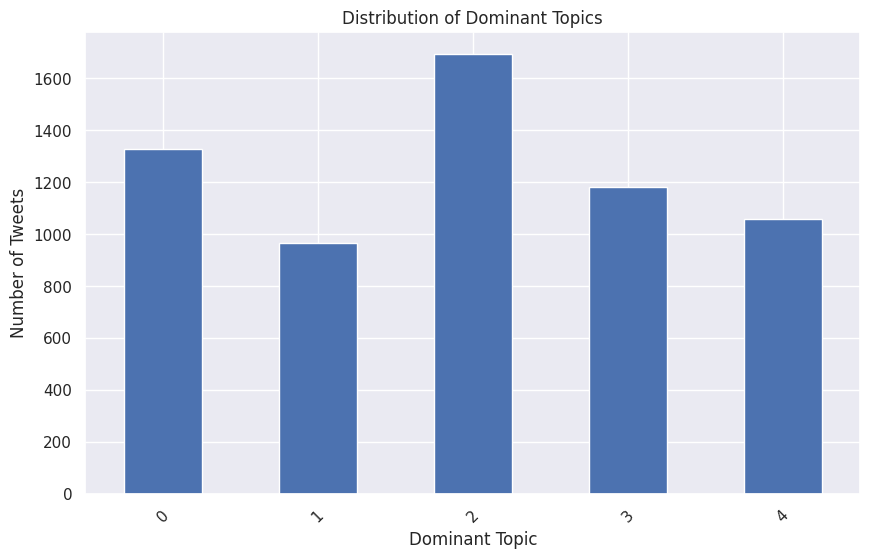

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string

# Tokenization using TweetTokenizer to handle special characters and emojis
tokenizer = TweetTokenizer()
data['clean_text'] = data['text'].apply(lambda x: tokenizer.tokenize(x))

# Custom stopword list including common Twitter-related terms
custom_stopwords = set(stopwords.words('english')) - {'not', 'no', 'nor', 'too'}
custom_stopwords.update(['rt', 'amp', '’', '...', '’', '…', '️'])

# Remove stopwords and punctuation, and convert to lowercase
data['clean_text'] = data['clean_text'].apply(lambda tokens: [token.lower() for token in tokens
                                                               if token.lower() not in custom_stopwords
                                                               and token.lower() not in string.punctuation])

# Create a dictionary representation of the documents
dictionary = Dictionary(data['clean_text'])

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert the dictionary to a bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in data['clean_text']]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)

# Print the topics with keywords
for topic_id, topic in lda_model.print_topics():
    print(f'Topic {topic_id}: {topic}')

# Get the dominant topic and its keywords for each document
data['dominant_topic'] = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]
data['topic_keywords'] = [lda_model.show_topic(topic_id) for topic_id in data['dominant_topic']]

# Display the DataFrame with dominant topics and keywords
print(data[['text', 'dominant_topic', 'topic_keywords']])

# Plot the distribution of topics
plt.figure(figsize=(10, 6))
topic_distribution = data['dominant_topic'].value_counts().sort_index()
topic_distribution.plot(kind='bar')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)

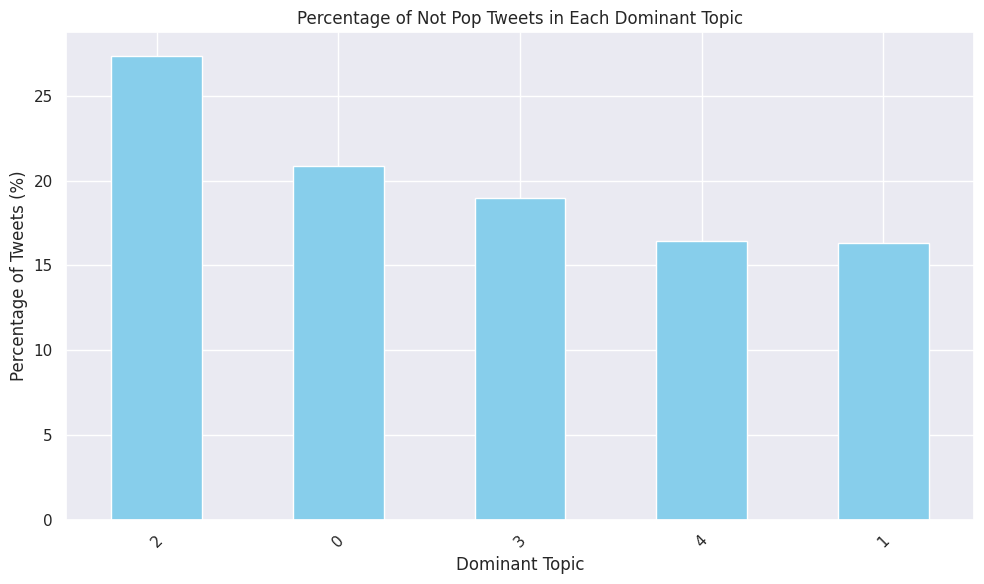

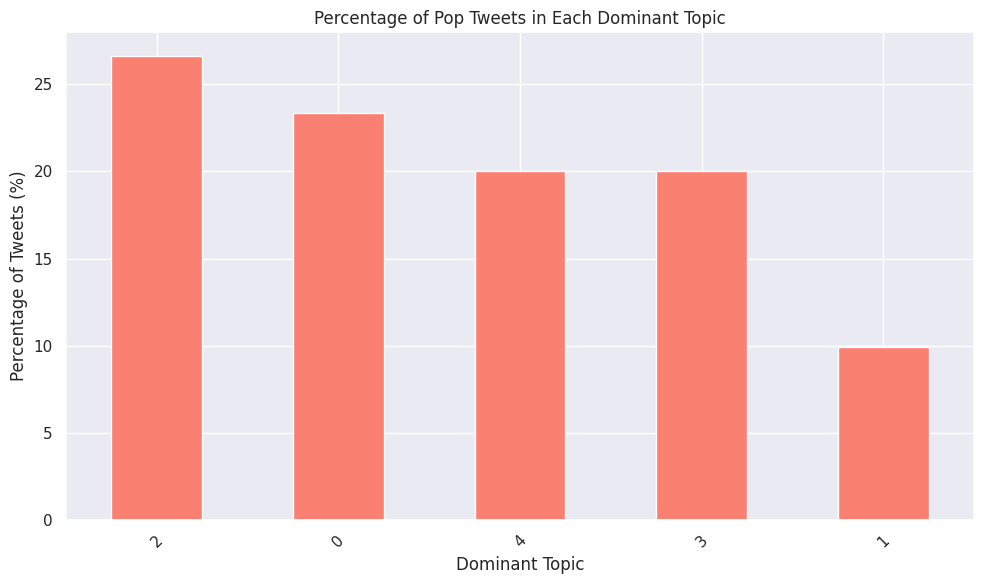

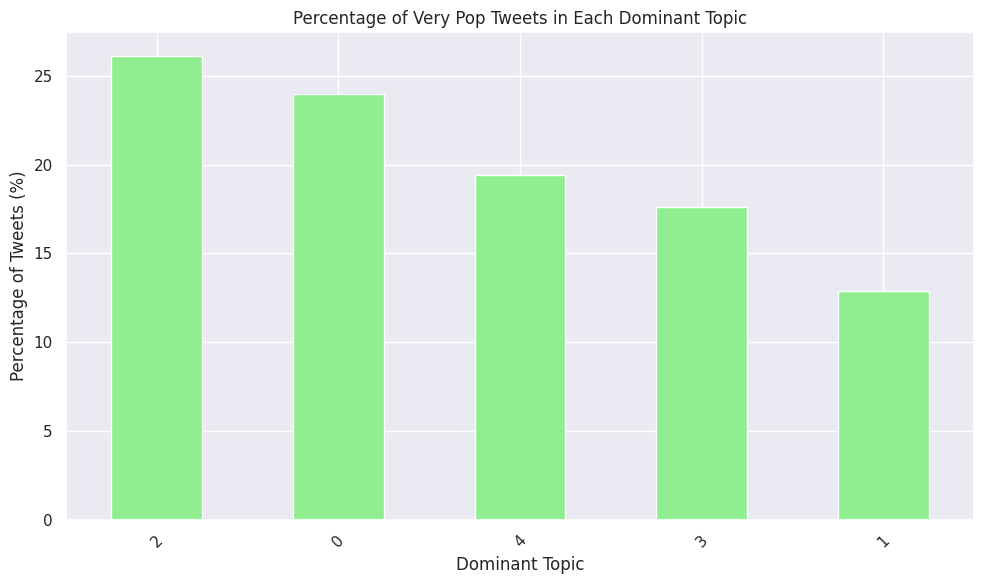

In [ ]:
import matplotlib.pyplot as plt

# Function to calculate percentage and plot bar graph
def plot_percentage_bar(data_subset, title, color):
    total_tweets = len(data_subset)
    topic_counts = data_subset['dominant_topic'].value_counts()
    topic_percentages = (topic_counts / total_tweets) * 100

    # Sort topics by percentage in descending order
    sorted_topics = topic_percentages.sort_values(ascending=False)

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    sorted_topics.plot(kind='bar', color=color)
    plt.xlabel('Dominant Topic')
    plt.ylabel('Percentage of Tweets (%)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Filter the data for 'not pop' tweets
not_pop_tweets = data[data['popularity'] == 'not pop']
plot_percentage_bar(not_pop_tweets, 'Percentage of Not Pop Tweets in Each Dominant Topic', 'skyblue')

# Filter the data for 'pop' tweets
pop_tweets = data[data['popularity'] == 'pop']
plot_percentage_bar(pop_tweets, 'Percentage of Pop Tweets in Each Dominant Topic', 'salmon')

# Filter the data for 'very pop' tweets
very_pop_tweets = data[data['popularity'] == 'very pop']
plot_percentage_bar(very_pop_tweets, 'Percentage of Very Pop Tweets in Each Dominant Topic', 'lightgreen')


comment: no obvious dominant topic that's different between the popularity levels



##MACHINE LEARNING
* predicting popularity (not pop, pop and very pop) of a tweet

*Definitions*:
* False Negatives (for very pop) - wrongly predicts ‘very pop’ tweets as ‘not pop’ and ‘pop’

* False Positives (for very pop) - wrongly predicts ‘not pop’ or ‘pop’ tweets as ‘very pop'

* recall rate: TP / (TP + FN)
* precision rate: TP / (TP + FP)
* f1-score: harmonic mean of precisiona nd recall.

Both recall and precision rates are important to ensure our models are able to identify relevant terms (low FNs) and minimize noise from FPs which will affect the thresholds. With the fact that our dataset has imbalanced classes (5k+, 500+, 500+). Therefore, f1-score will be used for evaluation.

# Random Forest Classifier


Random tree with predictors: fav and common_words_count (found in pop tweets)

Training Accuracy: 0.9106425702811245
Testing Accuracy: 0.8827309236947791

Training Classification Report:
              precision    recall  f1-score   support

     not pop       0.92      0.98      0.95      4145
         pop       0.86      0.76      0.81       433
    very pop       0.68      0.33      0.44       402

    accuracy                           0.91      4980
   macro avg       0.82      0.69      0.73      4980
weighted avg       0.90      0.91      0.90      4980

Testing Classification Report:
              precision    recall  f1-score   support

     not pop       0.92      0.97      0.94      1061
         pop       0.73      0.59      0.65        81
    very pop       0.38      0.22      0.28       103

    accuracy                           0.88      1245
   macro avg       0.67      0.59      0.63      1245
weighted avg       0.86      0.88      0.87      1245



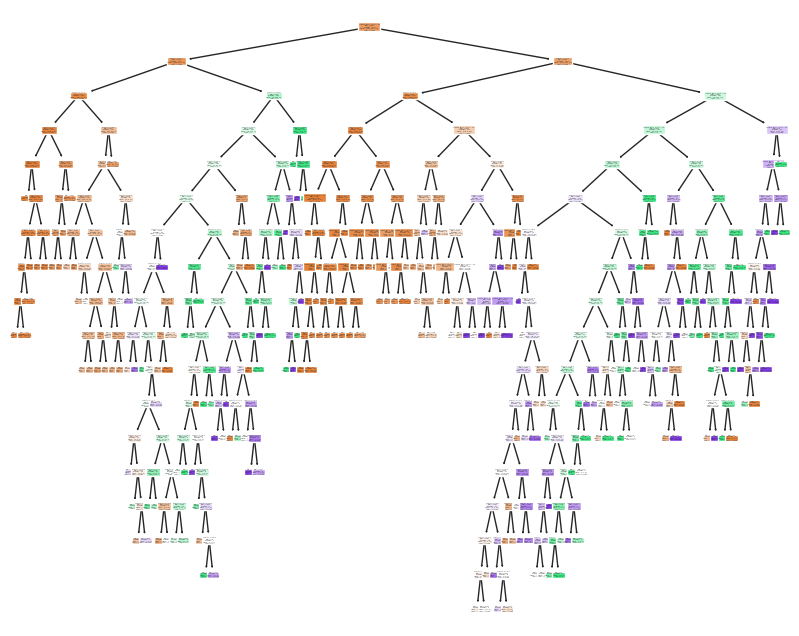

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree

# Define predictors and target variable
X = data[['favorites', 'common_words_count']]
y = data['popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = clf.predict(X_train)

# Make predictions on the test set
y_test_pred = clf.predict(X_test)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)
print()

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Evaluate the model on test data
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

# Enlarge the figure size and plot the first decision tree in the Random Forest
plt.figure(figsize=(10, 8))  # Adjust the figsize here (width, height)
plot_tree(clf.estimators_[0], feature_names=X.columns, class_names=['not pop', 'pop', 'very pop'], filled=True)
plt.show()


RF With finetuning
- using GridSearchCV to tune max_depth, minimum samples leaf and n_estimators

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util


Testing Accuracy: 0.8947791164658635
Testing Classification Report:
              precision    recall  f1-score   support

     not pop       0.92      0.98      0.95      1061
         pop       0.72      0.72      0.72        81
    very pop       0.45      0.15      0.22       103

    accuracy                           0.89      1245
   macro avg       0.70      0.61      0.63      1245
weighted avg       0.87      0.89      0.87      1245



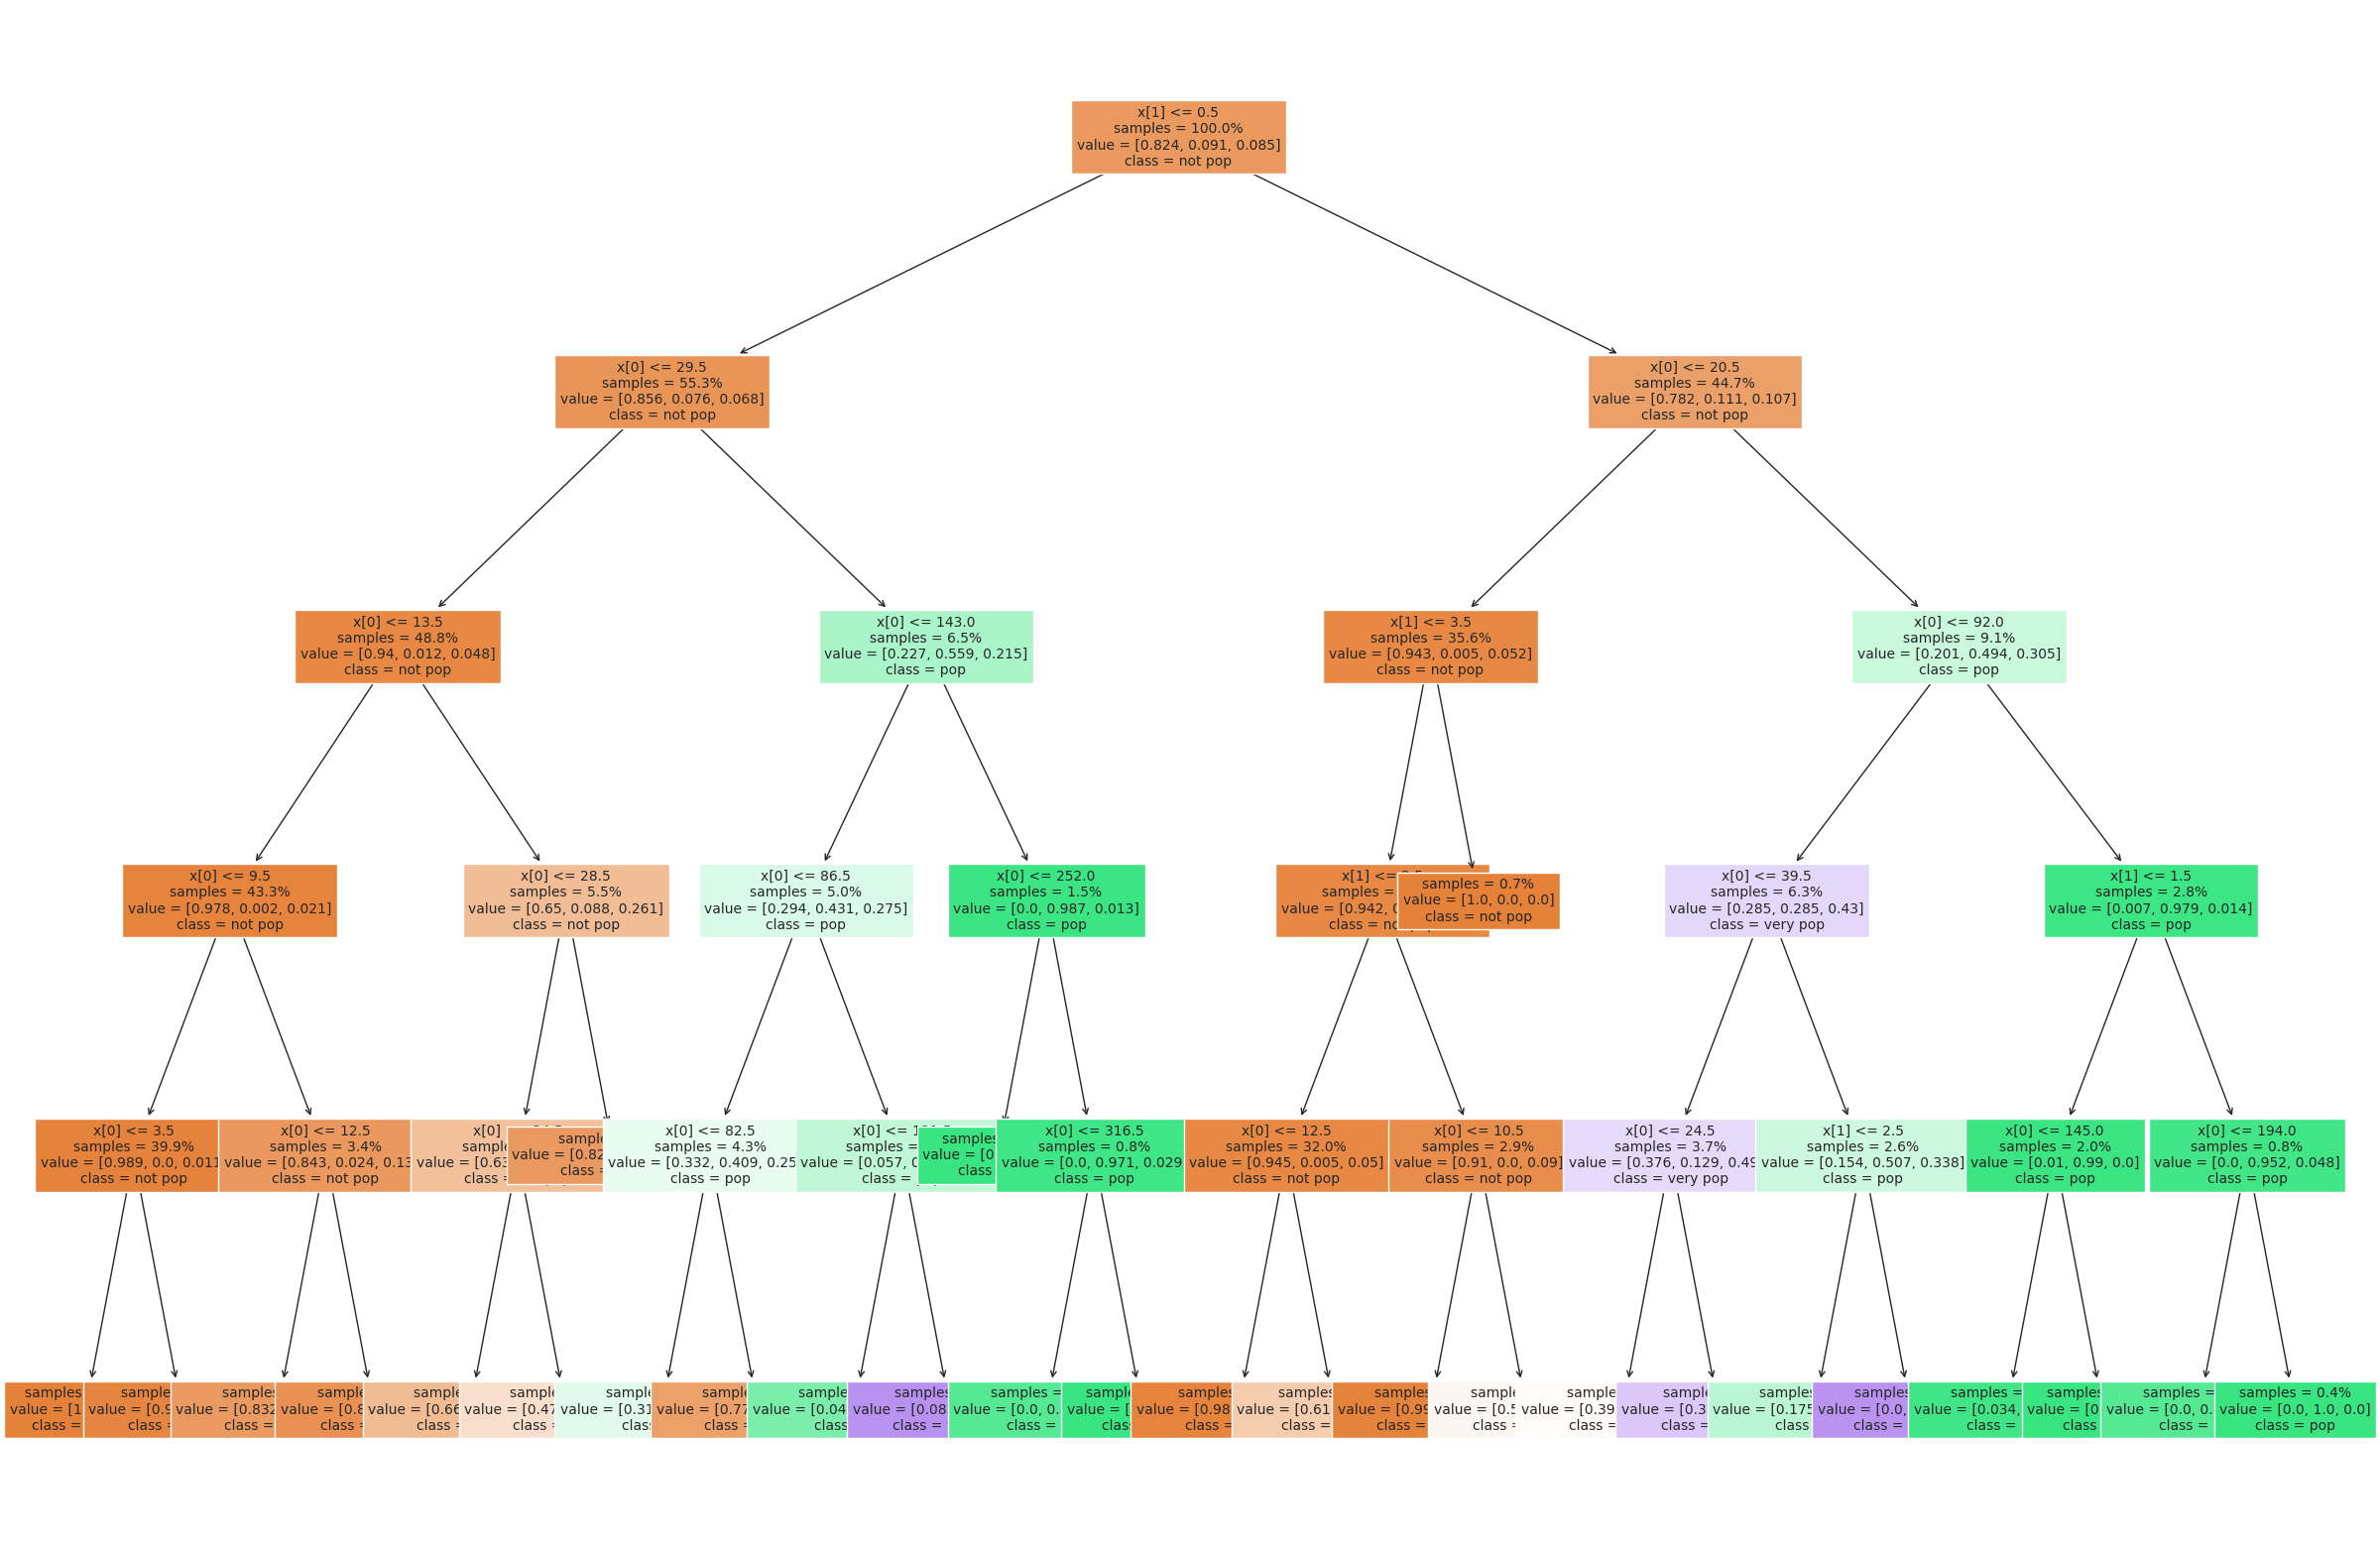

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_test, y_test are your training and testing data

# Define hyperparameters grid for tuning
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [None, 5, 10],
    'n_estimators': [100, 200, 300]
}

# Initialize Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Train the classifier with tuned hyperparameters
clf = RandomForestClassifier(**best_params, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = clf.predict(X_test)

# Evaluate the model on test data
class_names = ['not pop', 'pop', 'very pop']
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nTesting Accuracy:", test_accuracy)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Enlarge the figure size and plot the first decision tree in the Random Forest
plt.figure(figsize=(30, 20), dpi=100)   # Adjust the figsize here (width, height)
plot_tree(clf.estimators_[0], class_names=class_names, filled=True, fontsize=10, impurity=False, proportion=True)
plt.show()


In [ ]:
# Get feature importances from the trained Random Forest classifier
feature_importances = clf.feature_importances_

# Find the index of 'favorites' and 'common_words_count' features in X_train.columns
favorites_index = X_train.columns.get_loc('favorites')
common_words_count_index = X_train.columns.get_loc('common_words_count')

# Print the threshold values for 'favorites' and 'common_words_count'
favorites_threshold = feature_importances[favorites_index]
common_words_count_threshold = feature_importances[common_words_count_index]

print("Feature importance:")
print("Threshold for 'favorites':", favorites_threshold)
print("Threshold for 'common_words_count':", common_words_count_threshold)


Feature importance:
Threshold for 'favorites': 0.9855247603368446
Threshold for 'common_words_count': 0.014475239663155528


- favorites is more important feature used to predict popularity. Major limitation is that favorites is driven by exposure, which depends on popularity. Both are co-dependant, but it definitely seems like getting followers to save a post boosts the algorithm.

# Logistic Regression using BoW (Bag-of-Words)

BoW is a technique in natural language processing (NLP) for text representation. It's a way of converting text data into numerical vectors that machine learning algorithms can understand.

In [ ]:
# Import necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
X = data['clean_text']  # Text data
X = [' '.join(tokens) for tokens in X]
y = data['popularity']  # Response variable

# Create Bag-of-Words representations
vect = CountVectorizer()
vect.fit(X)

CountVectorizer()

In BoW, textual data is represented as a multiset (bag) of its words, disregarding grammar and word order. First, a vocabulary is created from all unique words in the collection of tweets. Then, each word is represented by a vector where each word corresponds to the frequency in the tweets.

In [ ]:
print("Tweet size: {}". format(len(vect.vocabulary_)))
print("Tweet content:\n {}". format(vect.vocabulary_))

Tweet size: 17617
Tweet content:
 {'starlink': 14237, 'arrived': 1889, 'pretty': 11835, 'quickly': 12332, 'ukraine': 15591, 'slavaukraini': 13892, 'ukrainerussiawar': 15615, 'https': 7177, 'co': 3507, 'dbgztafk8p': 4193, 'swearing': 14594, 'art': 1895, 'form': 5927, 'fckptn': 5619, 'r21adnnep6': 12391, 'strategywoman': 14369, 'much': 10072, 'love': 9181, 'southern': 14064, 'highlands': 6973, 'nsw': 10598, 'australia': 2032, '87po1ns6tv': 971, 'knew': 8554, 'almost': 1576, 'nothing': 10552, 'ukrainian': 15630, 'people': 11406, 'past': 11309, 'week': 16515, 'stand': 14215, 'awe': 2075, 'resilience': 12778, 'show': 13735, 'support': 14521, 'standwithukriane': 14228, 'tomorrow': 15129, 'quad': 12319, '5pm': 731, 'g8xwom6kjy': 6172, 'jo_whiteheaduk': 8088, 'abbieferdinand1': 1232, 'tories': 15151, 'loved': 9183, 'farmers': 5572, 'russians': 13163, 'there': 14944, 'no': 10499, 'worries': 16749, 'dnhadydgko': 4643, 'interesting': 7671, 'becomes': 2329, '21st': 292, 'century': 3212, 'pasaran':

In [ ]:
bag_of_words = vect.transform(X)
print(bag_of_words)

  (0, 1889)	1
  (0, 3507)	1
  (0, 4193)	1
  (0, 7177)	1
  (0, 11835)	1
  (0, 12332)	1
  (0, 13892)	1
  (0, 14237)	1
  (0, 15591)	1
  (0, 15615)	1
  (1, 1895)	1
  (1, 3507)	1
  (1, 5619)	1
  (1, 5927)	1
  (1, 7177)	1
  (1, 12391)	1
  (1, 13892)	1
  (1, 14594)	1
  (1, 15591)	1
  (2, 971)	1
  (2, 2032)	1
  (2, 3507)	1
  (2, 6973)	1
  (2, 7177)	1
  (2, 9181)	1
  :	:
  (6222, 14226)	1
  (6222, 15194)	1
  (6222, 15591)	1
  (6223, 2151)	1
  (6223, 3507)	1
  (6223, 4273)	1
  (6223, 5869)	1
  (6223, 7177)	1
  (6223, 7487)	1
  (6223, 9162)	1
  (6223, 10549)	1
  (6223, 11623)	1
  (6223, 12539)	1
  (6223, 14226)	1
  (6223, 15625)	1
  (6224, 3507)	1
  (6224, 6449)	1
  (6224, 7177)	1
  (6224, 7955)	1
  (6224, 8695)	1
  (6224, 9968)	1
  (6224, 13892)	1
  (6224, 14308)	1
  (6224, 15591)	1
  (6224, 15630)	1


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Bag-of-Words representations on train data set
bow_vectorizer = CountVectorizer(max_features = 10000)
bow_X_train = bow_vectorizer.fit_transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

Logistic Regression is an algorithm used for binary classification. When combined with BoW vectorization, it forms a method for text classification.

After converting text data into BoW vectors, logistic regression learns a linear relationship between the input features (BoW vectors) and the binary target variable (e.g., Popularity - very pop, pop or not pop). It computes the probability that a given input belongs to a particular class using the logistic function

In [ ]:
# Train logistic regression model
logistic_regression_model = LogisticRegression(C=10, max_iter=500, random_state=1)
logistic_regression_model.fit(bow_X_train, y_train)

# Make predictions
y_pred_train = logistic_regression_model.predict(bow_X_train)
y_pred_test = logistic_regression_model.predict(bow_X_test)

# Evaluate model performance
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("\nClassification Report (Training Data):\n", classification_report(y_train, y_pred_train))
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred_test))


Train Accuracy: 0.9967871485943776
Test Accuracy: 0.8096385542168675

Classification Report (Training Data):
               precision    recall  f1-score   support

     not pop       1.00      1.00      1.00      4145
         pop       1.00      0.98      0.99       433
    very pop       1.00      0.99      0.99       402

    accuracy                           1.00      4980
   macro avg       1.00      0.99      0.99      4980
weighted avg       1.00      1.00      1.00      4980


Classification Report (Test Data):
               precision    recall  f1-score   support

     not pop       0.86      0.94      0.90      1061
         pop       0.16      0.09      0.11        81
    very pop       0.12      0.06      0.08       103

    accuracy                           0.81      1245
   macro avg       0.38      0.36      0.36      1245
weighted avg       0.76      0.81      0.78      1245



Comment: Model is good at identifying not popular tweets but bad at predicting pop and very pop tweets - indicated by low f1-score
- consistent with EDA that there is not much difference between words used in each popularity class
- surprising it can predict non-pop tweets with high accuracy

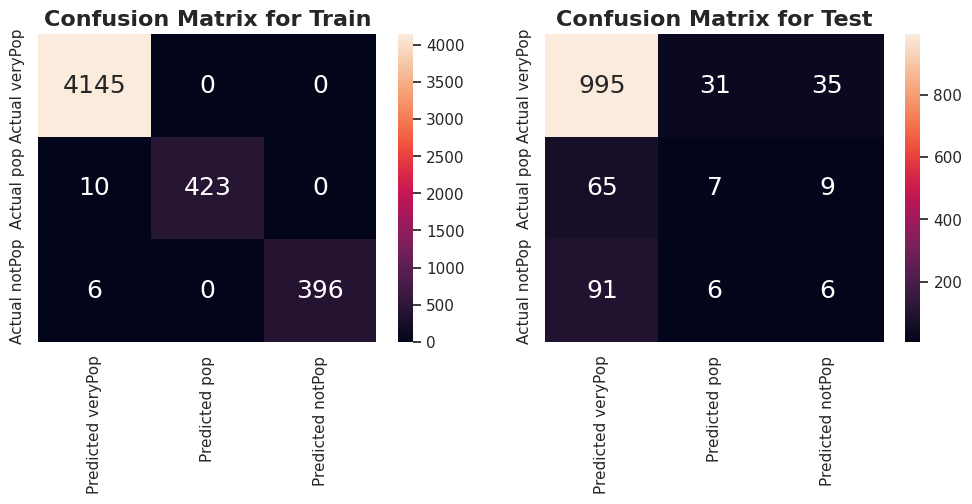

In [ ]:
conf_mat1 = confusion_matrix(y_train, y_pred_train)
conf_mat2 = confusion_matrix(y_test, y_pred_test)

# Define custom labels
predicted_labels = ["Predicted veryPop", "Predicted pop", "Predicted notPop"]
actual_labels = ["Actual veryPop", "Actual pop", "Actual notPop"]

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot confusion matrices using seaborn heatmap
sb.heatmap(conf_mat1, annot=True, fmt=".0f", annot_kws={"size": 18},
           xticklabels=predicted_labels, yticklabels=actual_labels, ax=axes[0])
sb.heatmap(conf_mat2, annot=True, fmt=".0f", annot_kws={"size": 18},
           xticklabels=predicted_labels, yticklabels=actual_labels, ax=axes[1])

# Add headers
axes[0].set_title('Confusion Matrix for Train', fontsize=16, fontweight='bold')
axes[1].set_title('Confusion Matrix for Test', fontsize=16, fontweight='bold')

# Show the plots
plt.show()